In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import svm
import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
import joblib

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Read CSV

In [2]:
df = pd.read_csv("../input/adni1-final/Gene_Data_Adni_1.csv").drop(["Unnamed: 0","Unnamed: 0.1","Unnamed: 0.2","Unnamed: 0.3","Unnamed: 0.4","ID"], axis=1)
prev_df = pd.read_csv("../input/adni1-final/Gene_Data_Adni_1.csv").drop(["Unnamed: 0","Unnamed: 0.1","Unnamed: 0.2","Unnamed: 0.3","Unnamed: 0.4","ID"], axis=1)

In [3]:
def map_gender(file,gender_dict):

    gender_dict = gender_dict
    file['gender'] = file['gender'].map(gender_dict) 
    
    return file

In [4]:
def map_label(file,diagnosis_dict):
    
    diagnosis_dict = diagnosis_dict
    file['label'] = file['label'].map(diagnosis_dict)
    
    return file

In [5]:
prev_df = map_gender(prev_df,{1.0: 1, 2.0: 2})
prev_df = map_label(prev_df,{1.0: 0, 2.0: 1,3.0:2})

df = map_gender(df,{1.0: 1, 2.0: 2})
df = map_label(df,{1.0: 0, 2.0: 1,3.0:1})

In [6]:
print(df)

     rs10460695  rs1150895  rs11666145  rs11702267  rs12126925  rs12405469  \
0             0          0           0           0           0           2   
1             0          0           0           0           1           1   
2             0          0           0           0           0           1   
3             1          0           0           1           0           1   
4             0          1           0           0           1           1   
..          ...        ...         ...         ...         ...         ...   
814           0          1           0           0           0           1   
815           0          0           0           1           2           0   
816           0          2           0           0           2           0   
817           1          0           0           0           1           0   
818           0          0           0           0           1           0   

     rs12482262  rs12482753  rs1295640  rs13049230  ...  rs7283

In [7]:
print(prev_df)

     rs10460695  rs1150895  rs11666145  rs11702267  rs12126925  rs12405469  \
0             0          0           0           0           0           2   
1             0          0           0           0           1           1   
2             0          0           0           0           0           1   
3             1          0           0           1           0           1   
4             0          1           0           0           1           1   
..          ...        ...         ...         ...         ...         ...   
814           0          1           0           0           0           1   
815           0          0           0           1           2           0   
816           0          2           0           0           2           0   
817           1          0           0           0           1           0   
818           0          0           0           0           1           0   

     rs12482262  rs12482753  rs1295640  rs13049230  ...  rs7283

# Classify if a Person has Alzheimer or Not

# Get Features and Labels

In [8]:
def get_features_label(df):
    
    features = df.drop('label',axis=1)
    label= df.label
    
    return features,label

In [9]:
features_first_classification,label_first_classification= get_features_label(df)

# Split Data into Training and Testing

In [10]:
def split_into_train_test(features,label):
    
    x_train,x_test,y_train,y_test = train_test_split(features,label,test_size=0.2,stratify=label,random_state = 42)
    
    return  x_train,x_test,y_train,y_test

In [11]:
x_train_1,x_test_1,y_train_1,y_test_1 = split_into_train_test(features_first_classification,label_first_classification)

# Apply Smoting

In [12]:
def smote(x_train,y_train,label1,label2):
    
    print("Before OverSampling, counts of label " + label1 +": {}".format(sum(y_train == 0)))
    print("Before OverSampling, counts of label " + label2 +": {} \n".format(sum(y_train == 1)))
  
    sm = SMOTE(random_state = 42)
    x_train,y_train = sm.fit_resample(x_train, y_train)
  
    print("After OverSampling, counts of label " + label1 +": {}".format(sum(y_train == 0)))
    print("After OverSampling, counts of label " + label2 +": {}".format(sum(y_train == 1)))
    
    return x_train,y_train
    

In [13]:
x_train_1,y_train_1 = smote(x_train_1,y_train_1 ,"CN","MCI_AD")

Before OverSampling, counts of label CN: 187
Before OverSampling, counts of label MCI_AD: 468 

After OverSampling, counts of label CN: 468
After OverSampling, counts of label MCI_AD: 468


# Helper Functions

In [14]:
def get_diagnosis_label(pred_label):
    
    diagnosis_pred = []
    for item in range(len(pred_label)):
        if pred_label[item] < 0.5:
             diagnosis_pred.append(0)
        else:
             diagnosis_pred.append(1)
    
    return diagnosis_pred

In [15]:
def get_average_acc(acc_list,n_splits):
    
    average_acc = []
    
    for i in range(int(len(acc_list)/n_splits)):
        average_acc.append(acc_list[i])
        
    for i in range(n_splits-1):
         for j in range(int(len(acc_list)/n_splits)):
                average_acc[j] = (average_acc[j] + acc_list[(j)+(i+1)*(int(len(acc_list)/n_splits))])
                
    for i in range(int(len(acc_list)/n_splits)):
        average_acc[i] = average_acc[i]/n_splits
                
    return average_acc

In [16]:
def get_max_acc_and_index(average_acc):
    
    max_item = 0
    for item in range(len(average_acc)):
        if max_item < average_acc[item]:
            max_item = average_acc[item]
            max_index = item
            
    return max_item,max_index

In [17]:
def get_accuracy(y_test,diagnosis_pred):
    
    actual_label = np.array(y_test)
    print("The accuracy score is:",accuracy_score(actual_label, diagnosis_pred)*100)

In [18]:
def confusion_matrix_print(actual_label,pred_label,label_name,classifier_name):
    
    ConfusionMatrix = confusion_matrix(actual_label,pred_label)
    sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
    plt.title(classifier_name + " Confusion Matrix\n")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [19]:
def roc_print(actual_label,test_data,classifier_used,classifier_name):
    
    yprob = classifier_used.predict_proba(test_data)
    RocAuc = roc_auc_score(actual_label,yprob[:,1])
    fpr, tpr, thresholds = roc_curve(actual_label,yprob[:,1])
    
    plt.figure()
    plt.title(classifier_name + " ROC Curve\n")
    plt.plot(fpr, tpr, label=classifier_name+' (The area = %0.2f)' % RocAuc)
    plt.plot([0, 1], [0, 1],'g--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [20]:
def plot_features_importance(classifier_used,train_data):
    
    features_importance = np.array(classifier_used.feature_importances_)
    feature_names = np.array(train_data.columns)

    data={'feature_names':feature_names,'features_importance':features_importance}
    feature_df = pd.DataFrame(data)

    feature_df.sort_values(by=['features_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,50))
    sns.barplot(x=feature_df['features_importance'], y=feature_df['feature_names'])
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [21]:
def save_load_check(classifier_used,saved_name,x_test,y_test,type_of_classifier):
    
    joblib.dump(classifier_used,saved_name)
    classifier = joblib.load(saved_name)
    
    pred_label=classifier.predict(x_test) 
    if type_of_classifier == 0:
        pred_label = get_diagnosis_label(pred_label)
        
    get_accuracy(y_test,pred_label)

# SVR Classification

In [22]:
label_name_1=["CN","AD-MCI"]

In [23]:
def svr_fit_predict(C_svr,degree_svr,coef0_svr,x_train,y_train,x_test):

    svr = svm.SVR(kernel="poly",C = C_svr,degree= degree_svr,coef0 = coef0_svr)
    svr.fit(x_train,y_train)
    pred_label_svr=svr.predict(x_test)  
    diagnosis_pred_svr = get_diagnosis_label(pred_label_svr)
    
    return svr,diagnosis_pred_svr

In [ ]:
def apply_svr(x_train,y_train,svr_n_splits):
    
    C = [0.1,1,10,100]
    degree = [2,3,4,5]
    coef0 =  [0,1,10,100]
    
    C_array = []
    degree_array = []
    coef0_array = []

    acc_list = []
    cv = KFold(n_splits=svr_n_splits, random_state=42, shuffle=True)

    for train_index, test_index in cv.split(x_train,y_train):
        
        x_tr = x_train.iloc[train_index]
        x_val = x_train.iloc[test_index]
        y_tr = y_train.iloc[train_index]
        y_val = y_train.iloc[test_index]
   
        actual_label = np.array(y_val)
    
        for i in range(len(C)):
            for j in range(len(degree)):
                for k in range(len(coef0)):
                    svr,diagnosis_pred_svr = svr_fit_predict(C[i],degree[j],coef0[k],x_tr,y_tr,x_val)
                    
                    acc_list.append(accuracy_score(actual_label,diagnosis_pred_svr)*100)
                    C_array.append(C[i])
                    degree_array.append(degree[j])
                    coef0_array.append(coef0[k])
                    print("accuracy is",acc_list[-1],"at C ",C[i],"at degree ",degree[j],"at coef0 ",coef0[k])
                                    
        print("--------------------------------------------------------------------------------")
        
    return acc_list,C_array,degree_array,coef0_array

In [ ]:
svr_n_splits_1 = 10

In [ ]:
acc_list_svr_1,C_array_svr_1,degree_array_svr_1,coef0_array_svr_1 = apply_svr(x_train_1,y_train_1,svr_n_splits_1)

In [ ]:
average_acc_svr_1 = get_average_acc(acc_list_svr_1,svr_n_splits_1)
print(average_acc_svr_1)

In [ ]:
max_item_svr_1,max_index_svr_1 = get_max_acc_and_index(average_acc_svr_1)
      
print("The maximum accuracy is: ",max_item_svr_1)
print("The maximum index is: ",max_index_svr_1)
print("The C at the maximum index is: ",C_array_svr_1[max_index_svr_1])
print("The degree at the maximum index is: ",degree_array_svr_1[max_index_svr_1])
print("The coef at the maximum index is: ",coef0_array_svr_1[max_index_svr_1])

In [24]:
#svr_1,diagnosis_pred_svr_1 = svr_fit_predict(C_array_svr_1[max_index_svr_1],degree_array_svr_1[max_index_svr_1],coef0_array_svr_1[max_index_svr_1],x_train_1,y_train_1,x_test_1)
svr_1,diagnosis_pred_svr_1 = svr_fit_predict(100,5,1,x_train_1.values,y_train_1,x_test_1)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


In [25]:
get_accuracy(y_test_1,diagnosis_pred_svr_1)

The accuracy score is: 68.29268292682927


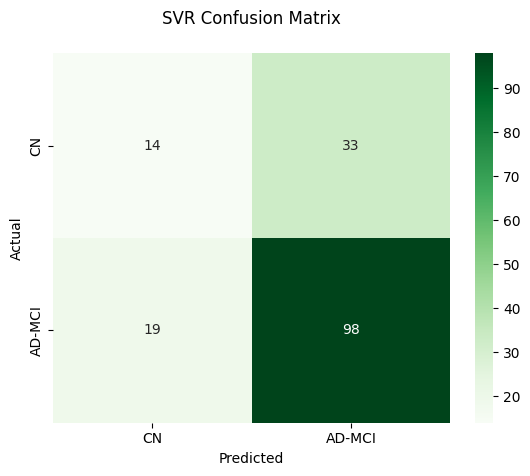

In [26]:
confusion_matrix_print(np.array(y_test_1),diagnosis_pred_svr_1,label_name_1,"SVR")

In [29]:
save_load_check(svr_1,"svr_1.pkl",x_test_1,y_test_1,0)

The accuracy score is: 68.29268292682927


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


# Random Forest Classification

In [30]:
def rf_fit_predict(n_estimators,max_depth,min_samples_split,min_samples_leaf,x_train,y_train,x_test):

    rf = RandomForestClassifier(n_estimators=n_estimators,max_depth = max_depth, min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,random_state=42)
    rf.fit(x_train,y_train)
    pred_label_rf = rf.predict(x_test)
    
    return rf,pred_label_rf

In [ ]:
def apply_rf(x_train,y_train,rf_n_splits):
    
    n_estimators = [100,300,500,700,1000]
    max_depth = [5,10,15,20]
    min_samples_split = [2,3,5,10,15]
    min_samples_leaf = [1,2,5,8,10]
    
    n_estimators_array = []
    max_depth_array = []
    min_samples_split_array = []
    min_samples_leaf_array = []
    
    acc_list = []
    cv = KFold(n_splits=rf_n_splits, random_state=42, shuffle=True)
    
    for train_index, test_index in cv.split(x_train):
        x_tr = x_train.iloc[train_index]
        x_val = x_train.iloc[test_index]
        y_tr = y_train.iloc[train_index]
        y_val = y_train.iloc[test_index]
        
        actual_label = np.array(y_val)
        
        for i in range(len(n_estimators)):
            for j in range(len(max_depth)):
                for k in range(len(min_samples_split)):
                    for l in range(len(min_samples_leaf)):
    
                        rf,pred_label_rf= rf_fit_predict(n_estimators[i],max_depth[j],min_samples_split[k],min_samples_leaf[l],x_tr,y_tr,x_val)
                                        
                        acc_list.append(accuracy_score(actual_label, pred_label_rf)*100)
                        print("accuracy is",acc_list[-1],"at n estimators ",n_estimators[i],"at max depth ",max_depth[j],"at min samples split ",min_samples_split[k],"at min simples leaf",min_samples_leaf[l])
                        n_estimators_array.append(n_estimators[i])
                        max_depth_array.append(max_depth[j])
                        min_samples_split_array.append(min_samples_split[k])
                        min_samples_leaf_array.append(min_samples_leaf[l])       
            
        print("--------------------------------------------------------------------------------")
         
    return acc_list,n_estimators_array,max_depth_array,min_samples_split_array,min_samples_leaf_array

In [ ]:
RF_number_of_splits_1 = 5

In [ ]:
acc_list_rf_1,n_estimators_array_rf_1,max_depth_array_rf_1,min_samples_split_array_rf_1,min_samples_leaf_array_rf_1 = apply_rf(x_train_1,y_train_1,RF_number_of_splits_1)

In [ ]:
average_acc_rf_1 = get_average_acc(acc_list_rf_1,RF_number_of_splits_1)
print(average_acc_rf_1)

In [ ]:
max_item_rf_1,max_index_rf_1 = get_max_acc_and_index(average_acc_rf_1)
      
print("The maximum accuracy is: ",max_item_rf_1)
print("The maximum index is: ",max_index_rf_1)
print("The n_estimators at the maximum index is: ",n_estimators_array_rf_1[max_index_rf_1])
print("The max depth at the maximum index is: ",max_depth_array_rf_1[max_index_rf_1])
print("The min samples split at the maximum index is: ",min_samples_split_array_rf_1[max_index_rf_1])
print("The min samples leaf at the maximum index is: ",min_samples_leaf_array_rf_1[max_index_rf_1])

In [31]:
#rf_1,pred_label_rf_1 =  rf_fit_predict(n_estimators_array_rf_1[max_index_rf_1],max_depth_array_rf_1[max_index_rf_1],min_samples_split_array_rf_1[max_index_rf_1],min_samples_leaf_array_rf_1[max_index_rf_1],x_train_1,y_train_1,x_test_1)
rf_1,pred_label_rf_1 =  rf_fit_predict(1000,15,2,1,x_train_1,y_train_1,x_test_1)

In [32]:
get_accuracy(y_test_1,pred_label_rf_1)

The accuracy score is: 73.17073170731707


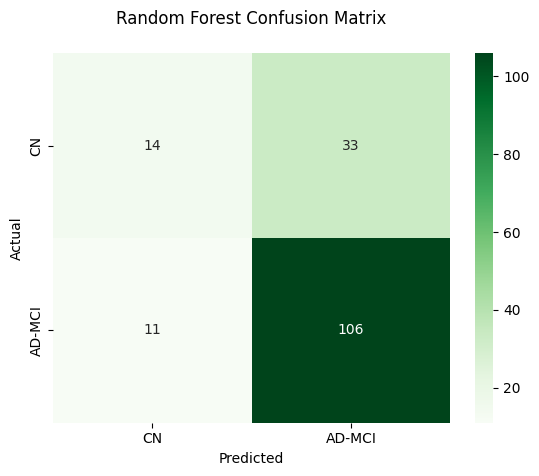

In [33]:
confusion_matrix_print(np.array(y_test_1),pred_label_rf_1,label_name_1,"Random Forest")

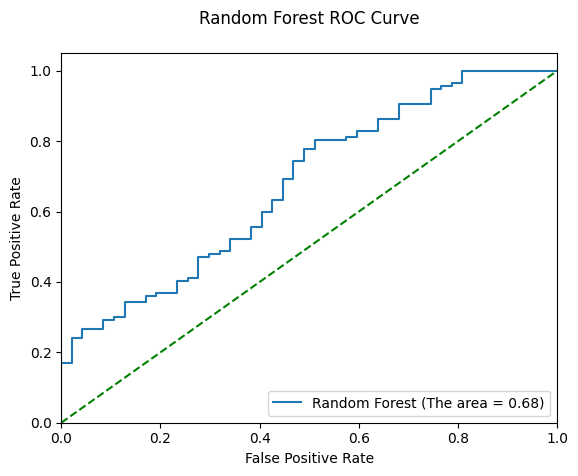

In [34]:
roc_print(np.array(y_test_1),x_test_1,rf_1,"Random Forest")

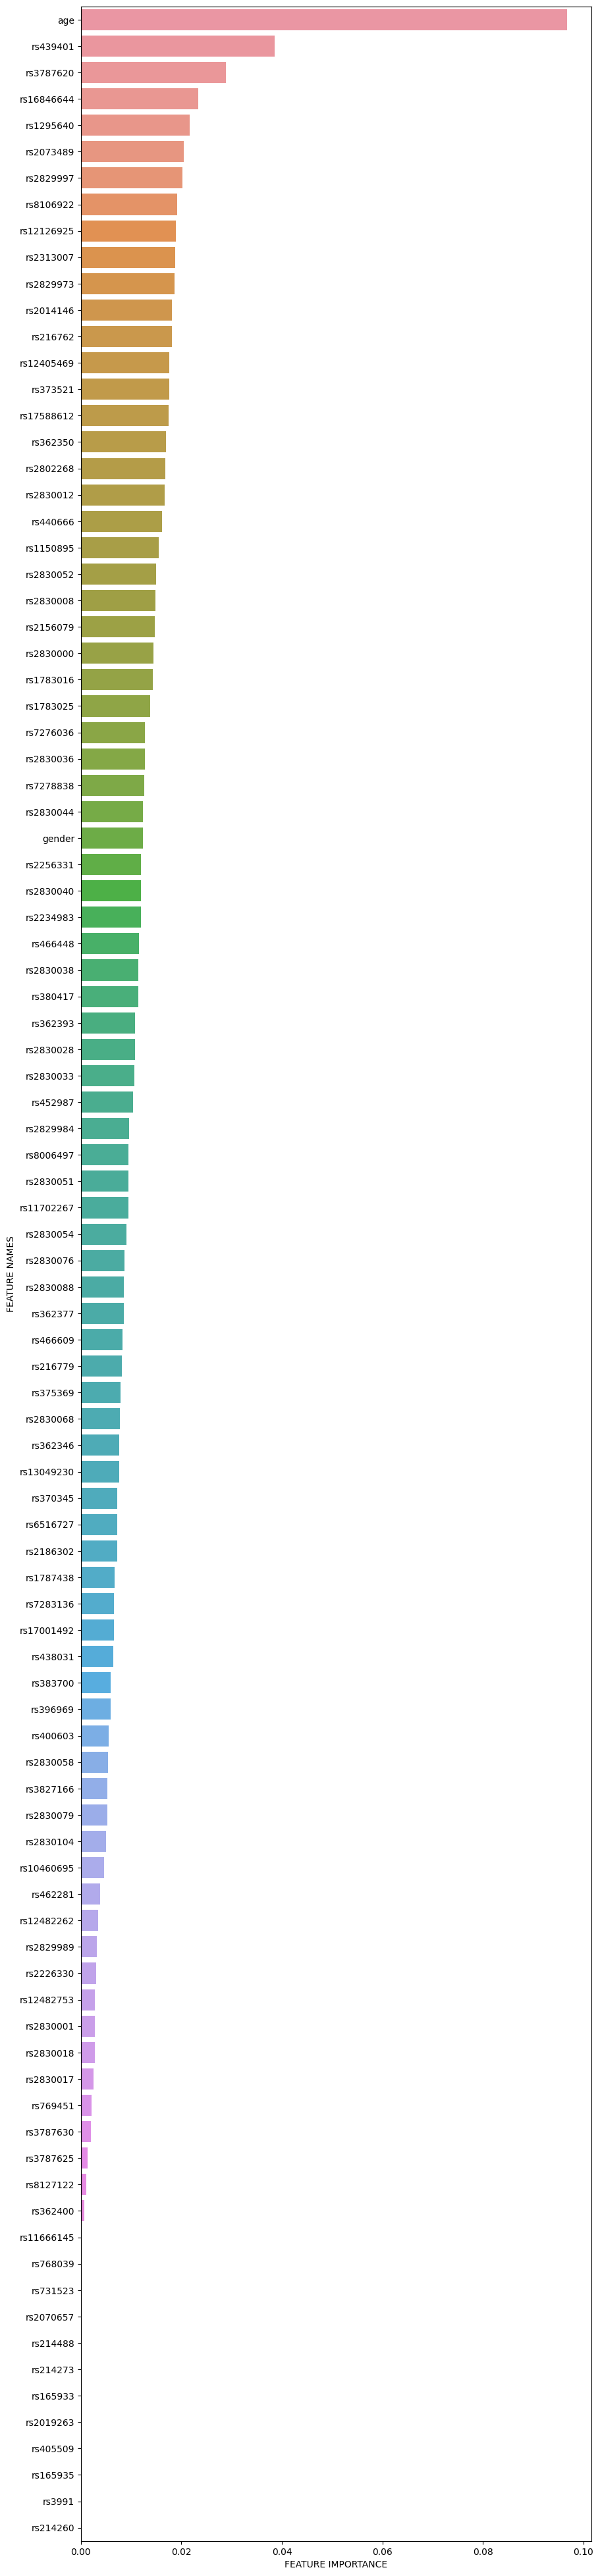

In [35]:
 plot_features_importance(rf_1,x_train_1)

In [36]:
save_load_check(rf_1,"rf_1.pkl",x_test_1,y_test_1,1)

The accuracy score is: 73.17073170731707


# XGBoost Classification

In [37]:
def xgb_fit_predict(max_depth,n_estimators,x_train,y_train,x_test):
    
    xgb = XGBClassifier(max_depth=max_depth,n_estimators=n_estimators,random_state=42)
    xgb.fit(x_train,y_train)
    pred_label_xgb=xgb.predict(x_test)
    
    return xgb,pred_label_xgb

In [ ]:
def apply_xgb(x_train,y_train,xgb_n_splits):
    
    max_depth = range(1,16)
    n_estimators = [100,300,500,700,1000]

    max_depth_array = []
    n_estimators_array = []

    acc_list = []
    cv = KFold(n_splits=xgb_n_splits, random_state=42, shuffle=True)
    
    for train_index, test_index in cv.split(x_train):
        x_tr = x_train.iloc[train_index]
        x_val = x_train.iloc[test_index]
        y_tr = y_train.iloc[train_index]
        y_val = y_train.iloc[test_index]
   
        actual_label = np.array(y_val)
    
        for i in range(len(max_depth)):
            for j in range(len(n_estimators)):
                
                xgb,pred_label_xgb = xgb_fit_predict(max_depth[i],n_estimators[j],x_tr,y_tr,x_val)
                
                acc_list.append(accuracy_score(actual_label, pred_label_xgb)*100)
                print("accuracy is",acc_list[-1],"at max depth ",max_depth[i],"at n estimators",n_estimators[j])
                max_depth_array.append(max_depth[i])
                n_estimators_array.append(n_estimators[j])
                    
        print("--------------------------------------------------------------------------------")
    
                                        
    return acc_list,max_depth_array,n_estimators_array

In [ ]:
XGB_number_of_splits_1 = 5

In [ ]:
acc_list_xgb_1,max_depth_array_xgb_1,n_estimators_array_xgb_1 = apply_xgb(x_train_1,y_train_1,XGB_number_of_splits_1)

In [ ]:
average_acc_xgb_1 = get_average_acc(acc_list_xgb_1,XGB_number_of_splits_1)
print(average_acc_xgb_1)

In [ ]:
max_item_xgb_1,max_index_xgb_1 = get_max_acc_and_index(average_acc_xgb_1)
      
print("The maximum accuracy is: ",max_item_xgb_1)
print("The maximum index is: ",max_index_xgb_1)
print("The max depth at the maximum index is: ",max_depth_array_xgb_1[max_index_xgb_1])
print("The n-estimators at the maximum index is: ",n_estimators_array_xgb_1[max_index_xgb_1])

In [38]:
#xgb_1,pred_label_xgb_1 = xgb_fit_predict(max_depth_array_xgb_1[max_index_xgb_1],n_estimators_array_xgb_1[max_index_xgb_1],x_train_1,y_train_1,x_test_1)
xgb_1,pred_label_xgb_1 = xgb_fit_predict(7,500,x_train_1,y_train_1,x_test_1)

In [39]:
get_accuracy(y_test_1,pred_label_xgb_1)

The accuracy score is: 73.17073170731707


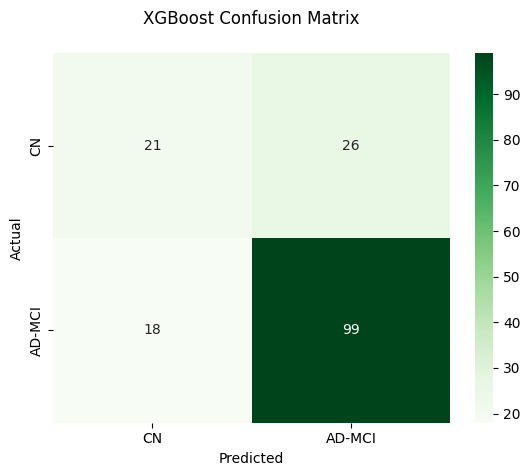

In [40]:
confusion_matrix_print(np.array(y_test_1),pred_label_xgb_1,label_name_1,"XGBoost")

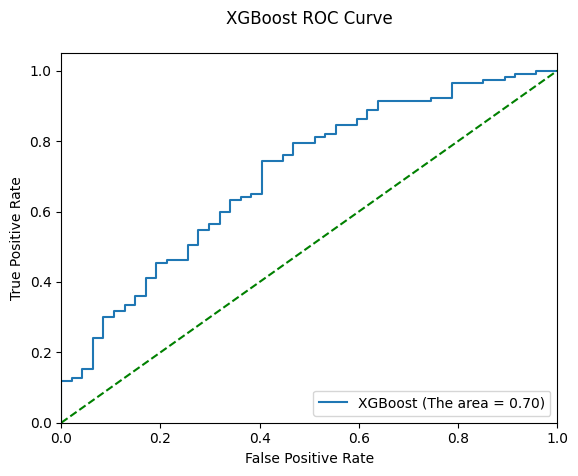

In [41]:
roc_print(np.array(y_test_1),x_test_1,xgb_1,"XGBoost")

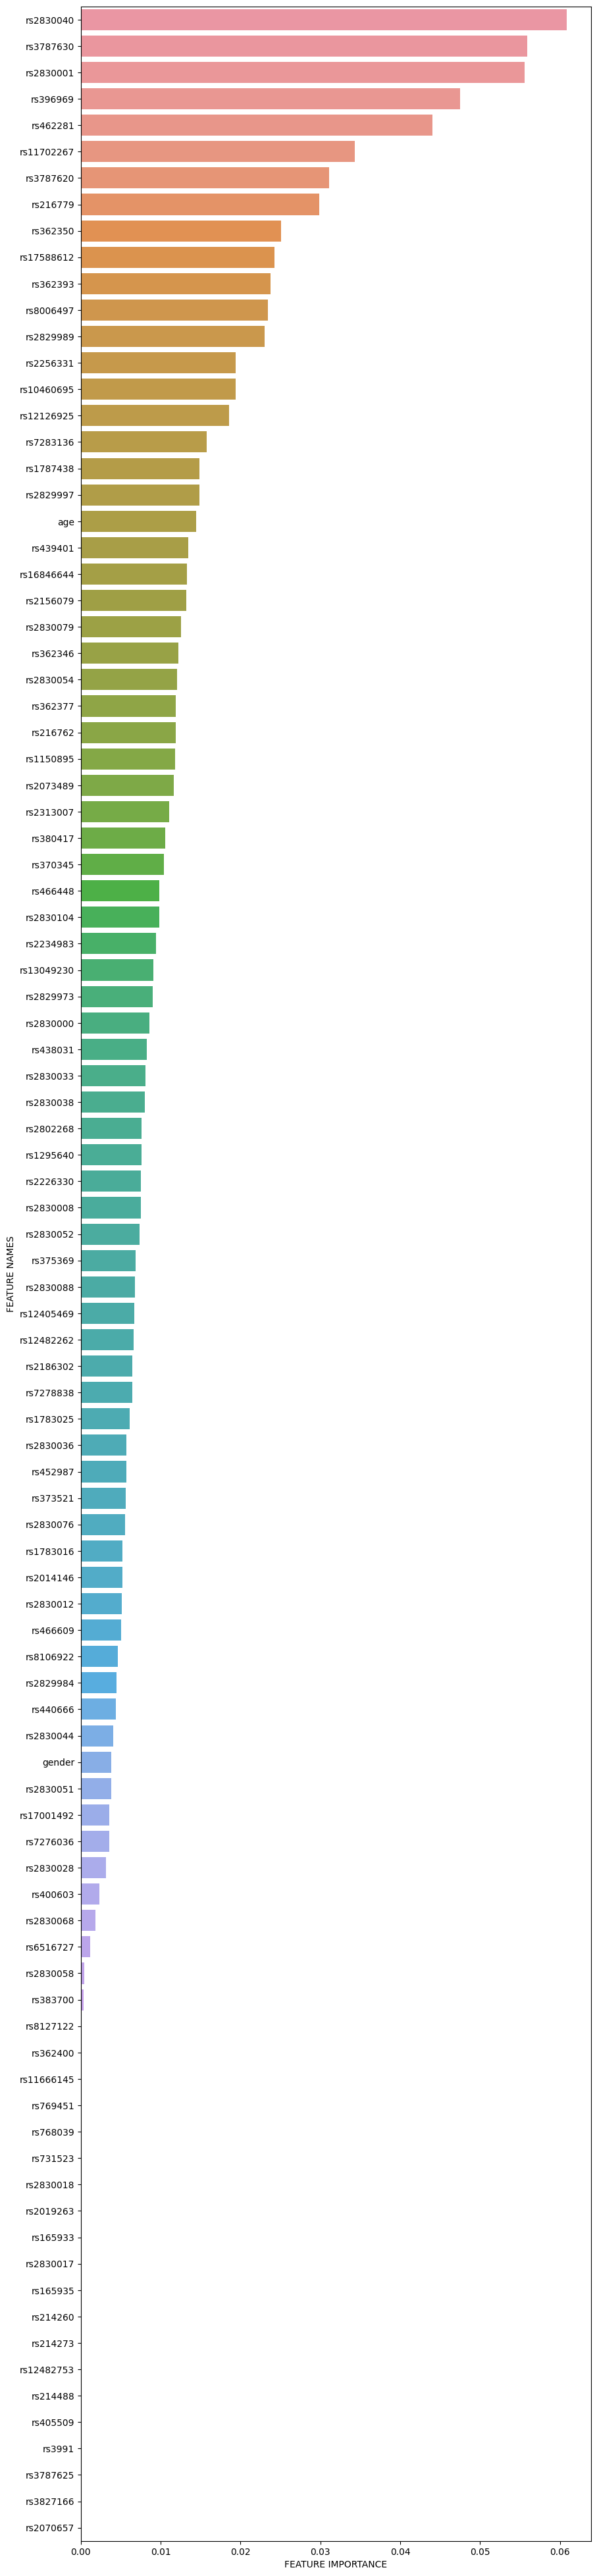

In [42]:
plot_features_importance(xgb_1,x_train_1)

In [43]:
save_load_check(xgb_1,"xgb_1.pkl",x_test_1,y_test_1,1)

The accuracy score is: 73.17073170731707


# Voting

In [44]:
def voting_helper_function(pred_label,voting_list):
    
    if pred_label== 0:
         voting_list[0] += 1
    elif pred_label == 1:
         voting_list[1] += 1

In [45]:
def voting(pred_label_svr,pred_label_rf,pred_label_xgb):
    
    predict_voting = []
    for i in range (len(pred_label_svr)):
        voting_list =[0, 0]
        voting_helper_function(pred_label_svr[i],voting_list)
        voting_helper_function(pred_label_rf[i],voting_list)
        voting_helper_function(pred_label_xgb[i],voting_list)  
        predict_voting.append(np.argmax(voting_list))
    
    print("The predicted labels of the combined classifiers are:",predict_voting)

    return predict_voting

In [46]:
predict_voting_1 = voting(diagnosis_pred_svr_1,pred_label_rf_1,pred_label_xgb_1)
print("The accuracy score of the combined classifiers is",accuracy_score(np.array(y_test_1),np.array(predict_voting_1))*100)

The predicted labels of the combined classifiers are: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0]
The accuracy score of the combined classifiers is 76.82926829268293


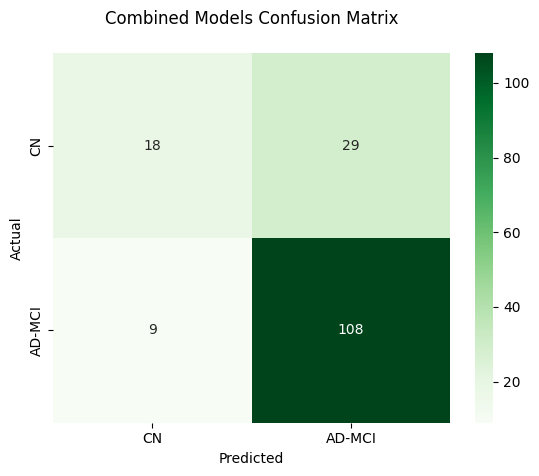

In [47]:
confusion_matrix_print(np.array(y_test_1),predict_voting_1,label_name_1,"Combined Models")

# 

# Classify if a Person is in the early or late stages of Alzheimer

# Remove Non_ill People

In [48]:
pred_features_svr=svr_1.predict(features_first_classification)
diagnosis_pred_features_svr = get_diagnosis_label(pred_features_svr)
diagnosis_pred_features_rf=rf_1.predict(features_first_classification)
diagnosis_pred_features_xgb = xgb_1.predict(features_first_classification)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


In [49]:
predict_voting_features = voting(diagnosis_pred_features_svr,diagnosis_pred_features_rf,diagnosis_pred_features_xgb)

The predicted labels of the combined classifiers are: [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 

In [50]:
def remove_predicted_label_0(features):
    
    count = 0
    for i in range(len(features)):
        if features[i]==0:
            count = count +1
            prev_df.drop([i], axis=0, inplace=True)
          
    print(count) 
    print(prev_df)

In [51]:
remove_predicted_label_0(predict_voting_features)

214
     rs10460695  rs1150895  rs11666145  rs11702267  rs12126925  rs12405469  \
1             0          0           0           0           1           1   
2             0          0           0           0           0           1   
3             1          0           0           1           0           1   
4             0          1           0           0           1           1   
5             1          0           0           0           0           1   
..          ...        ...         ...         ...         ...         ...   
814           0          1           0           0           0           1   
815           0          0           0           1           2           0   
816           0          2           0           0           2           0   
817           1          0           0           0           1           0   
818           0          0           0           0           1           0   

     rs12482262  rs12482753  rs1295640  rs13049230  ...  rs

# Number of Mis-classified People (Misclassified as not ill when they are ill)

In [52]:
print("Counts of label CN: {} \n".format(sum(prev_df.label == 0)))

Counts of label CN: 29 



# Drop Mis-classified

In [53]:
drop_zero = prev_df[(prev_df['label'] != 1) & (prev_df['label'] != 2)].index
prev_df.drop(drop_zero, inplace=True)
print(prev_df)                   

     rs10460695  rs1150895  rs11666145  rs11702267  rs12126925  rs12405469  \
2             0          0           0           0           0           1   
3             1          0           0           1           0           1   
4             0          1           0           0           1           1   
5             1          0           0           0           0           1   
6             0          0           0           0           0           1   
..          ...        ...         ...         ...         ...         ...   
813           0          0           0           0           0           2   
814           0          1           0           0           0           1   
815           0          0           0           1           2           0   
816           0          2           0           0           2           0   
817           1          0           0           0           1           0   

     rs12482262  rs12482753  rs1295640  rs13049230  ...  rs7283

# Check

In [54]:
print("Counts of label CN: {} \n".format(sum(prev_df.label == 0)))

Counts of label CN: 0 



# Mapping

In [55]:
# MCI 0 , AD 1
prev_df = map_label(prev_df,{1: 0, 2: 1})
print(prev_df)

     rs10460695  rs1150895  rs11666145  rs11702267  rs12126925  rs12405469  \
2             0          0           0           0           0           1   
3             1          0           0           1           0           1   
4             0          1           0           0           1           1   
5             1          0           0           0           0           1   
6             0          0           0           0           0           1   
..          ...        ...         ...         ...         ...         ...   
813           0          0           0           0           0           2   
814           0          1           0           0           0           1   
815           0          0           0           1           2           0   
816           0          2           0           0           2           0   
817           1          0           0           0           1           0   

     rs12482262  rs12482753  rs1295640  rs13049230  ...  rs7283

# Get Features and Labels

In [56]:
features_second_classification,label_second_classification = get_features_label(prev_df)

# Split Data into Training and Testing

In [57]:
x_train_2,x_test_2,y_train_2,y_test_2 = split_into_train_test(features_second_classification,label_second_classification)

# Apply Smoting

In [58]:
x_train_2,y_train_2= smote(x_train_2,y_train_2,"MCI","AD")

Before OverSampling, counts of label MCI: 308
Before OverSampling, counts of label AD: 152 

After OverSampling, counts of label MCI: 308
After OverSampling, counts of label AD: 308


# SVR Classification

In [59]:
label_name_2=["MCI","AD"]

In [ ]:
acc_list_svr_2,C_array_svr_2,degree_array_svr_2,coef0_array_svr_2 = apply_svr(x_train_2,y_train_2,svr_n_splits_1)

In [ ]:
average_acc_svr_2 = get_average_acc(acc_list_svr_2,svr_n_splits_1)
print(average_acc_svr_2)

In [ ]:
max_item_svr_2,max_index_svr_2 = get_max_acc_and_index(average_acc_svr_2)
      
print("The maximum accuracy is: ",max_item_svr_2)
print("The maximum index is: ",max_index_svr_2)
print("The C at the maximum index is: ",C_array_svr_2[max_index_svr_2])
print("The degree at the maximum index is: ",degree_array_svr_2[max_index_svr_2])
print("The coef at the maximum index is: ",coef0_array_svr_2[max_index_svr_2])

In [60]:
#svr_2,diagnosis_pred_svr_2 = svr_fit_predict(C_array_svr_2[max_index_svr_2],degree_array_svr_2[max_index_svr_2],coef0_array_svr_2[max_index_svr_2],x_train_2,y_train_2,x_test_2)
svr_2,diagnosis_pred_svr_2 = svr_fit_predict(100,5,1,x_train_2,y_train_2,x_test_2)

In [61]:
get_accuracy(y_test_2,diagnosis_pred_svr_2)

The accuracy score is: 63.793103448275865


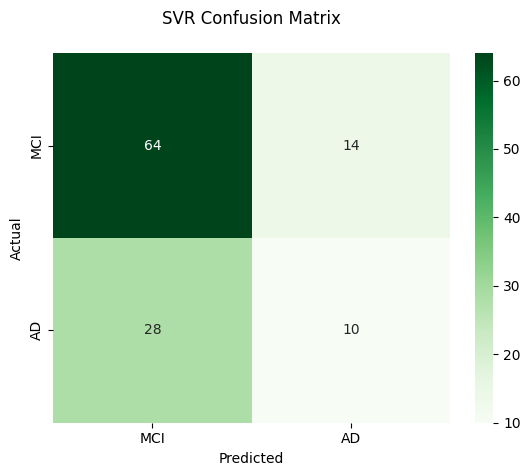

In [62]:
confusion_matrix_print(np.array(y_test_2),diagnosis_pred_svr_2,label_name_2,"SVR")

In [63]:
save_load_check(svr_2,"svr_2.pkl",x_test_2,y_test_2,0)

The accuracy score is: 63.793103448275865


# Random Forest Classification

In [64]:
rf_2,pred_label_rf_2 =  rf_fit_predict(1000,15,2,1,x_train_2,y_train_2,x_test_2)

In [65]:
get_accuracy(y_test_2,pred_label_rf_2)

The accuracy score is: 68.96551724137932


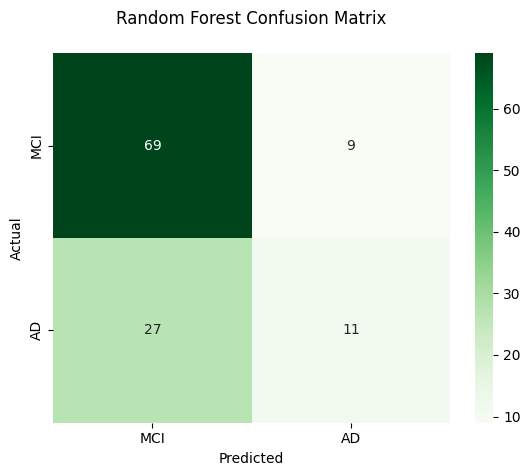

In [66]:
confusion_matrix_print(np.array(y_test_2),pred_label_rf_2,label_name_2,"Random Forest")

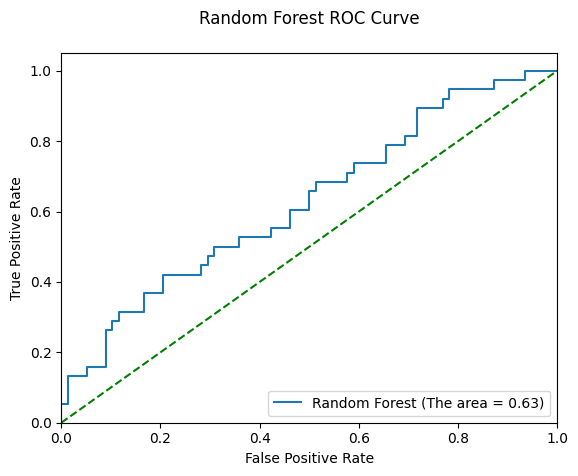

In [67]:
roc_print(np.array(y_test_2),x_test_2,rf_2,"Random Forest")

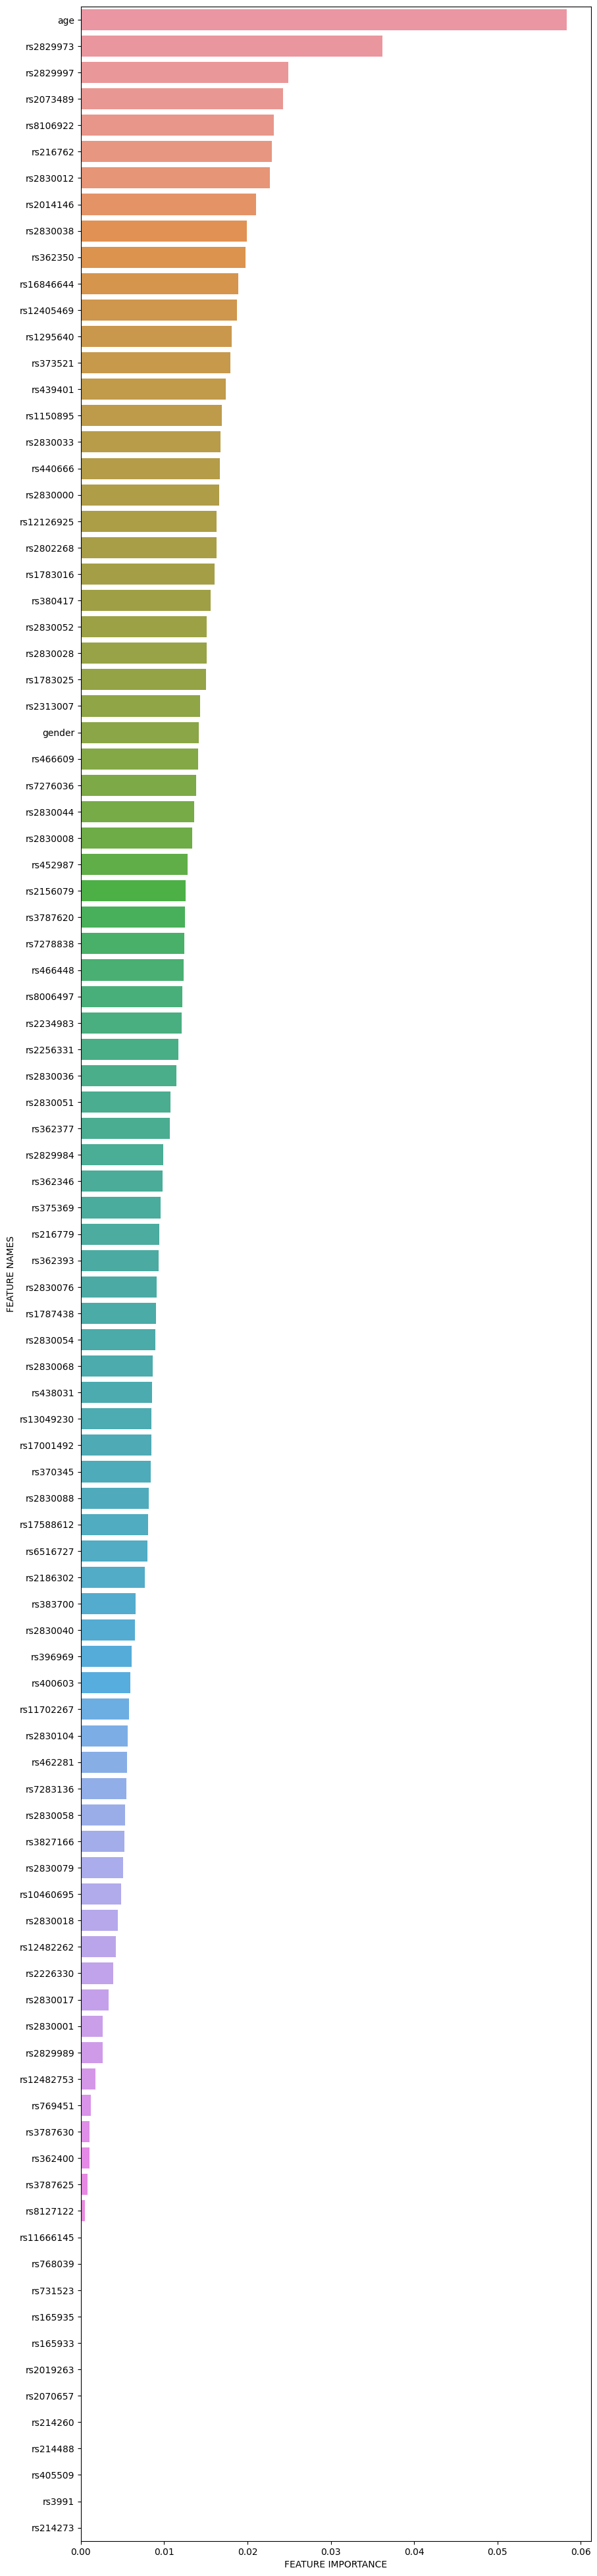

In [68]:
 plot_features_importance(rf_2,x_train_2)

In [69]:
save_load_check(rf_2,"rf_2.pkl",x_test_2,y_test_2,1)

The accuracy score is: 68.96551724137932


# XGBoost Classification

In [ ]:
acc_list_xgb_2,max_depth_array_xgb_2,n_estimators_array_xgb_2 = apply_xgb(x_train_2,y_train_2,XGB_number_of_splits_1)

In [ ]:
average_acc_xgb_2 = get_average_acc(acc_list_xgb_2,XGB_number_of_splits_1)
print(average_acc_xgb_2)

In [ ]:
max_item_xgb_2,max_index_xgb_2 = get_max_acc_and_index(average_acc_xgb_2)
      
print("The maximum accuracy is: ",max_item_xgb_2)
print("The maximum index is: ",max_index_xgb_2)
print("The max depth at the maximum index is: ",max_depth_array_xgb_2[max_index_xgb_2])
print("The n-estimators at the maximum index is: ",n_estimators_array_xgb_2[max_index_xgb_2])

In [70]:
#xgb_2,pred_label_xgb_2 = xgb_fit_predict(max_depth_array_xgb_2[max_index_xgb_2],n_estimators_array_xgb_2[max_index_xgb_2],x_train_2,y_train_2,x_test_2)
#xgb_2,pred_label_xgb_2 = xgb_fit_predict(15,300,x_train_2,y_train_2,x_test_2)
xgb_2,pred_label_xgb_2 = xgb_fit_predict(7,500,x_train_2,y_train_2,x_test_2)

In [71]:
get_accuracy(y_test_2,pred_label_xgb_2)

The accuracy score is: 69.82758620689656


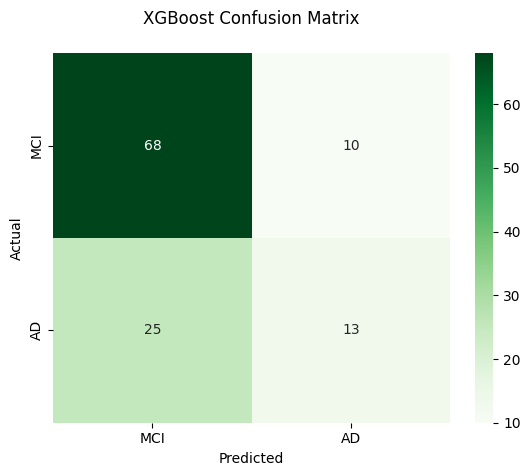

In [72]:
confusion_matrix_print(np.array(y_test_2),pred_label_xgb_2,label_name_2,"XGBoost")

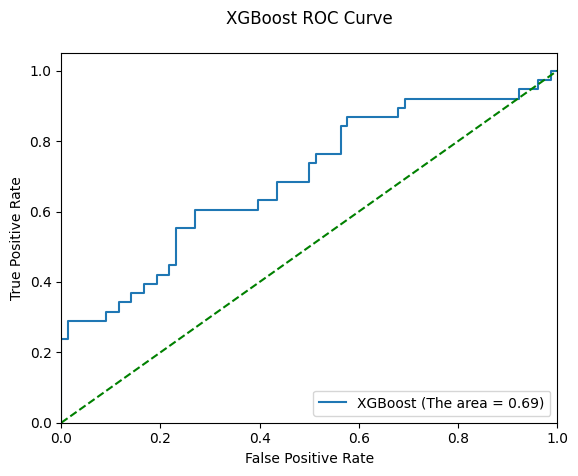

In [73]:
roc_print(np.array(y_test_2),x_test_2,xgb_2,"XGBoost")

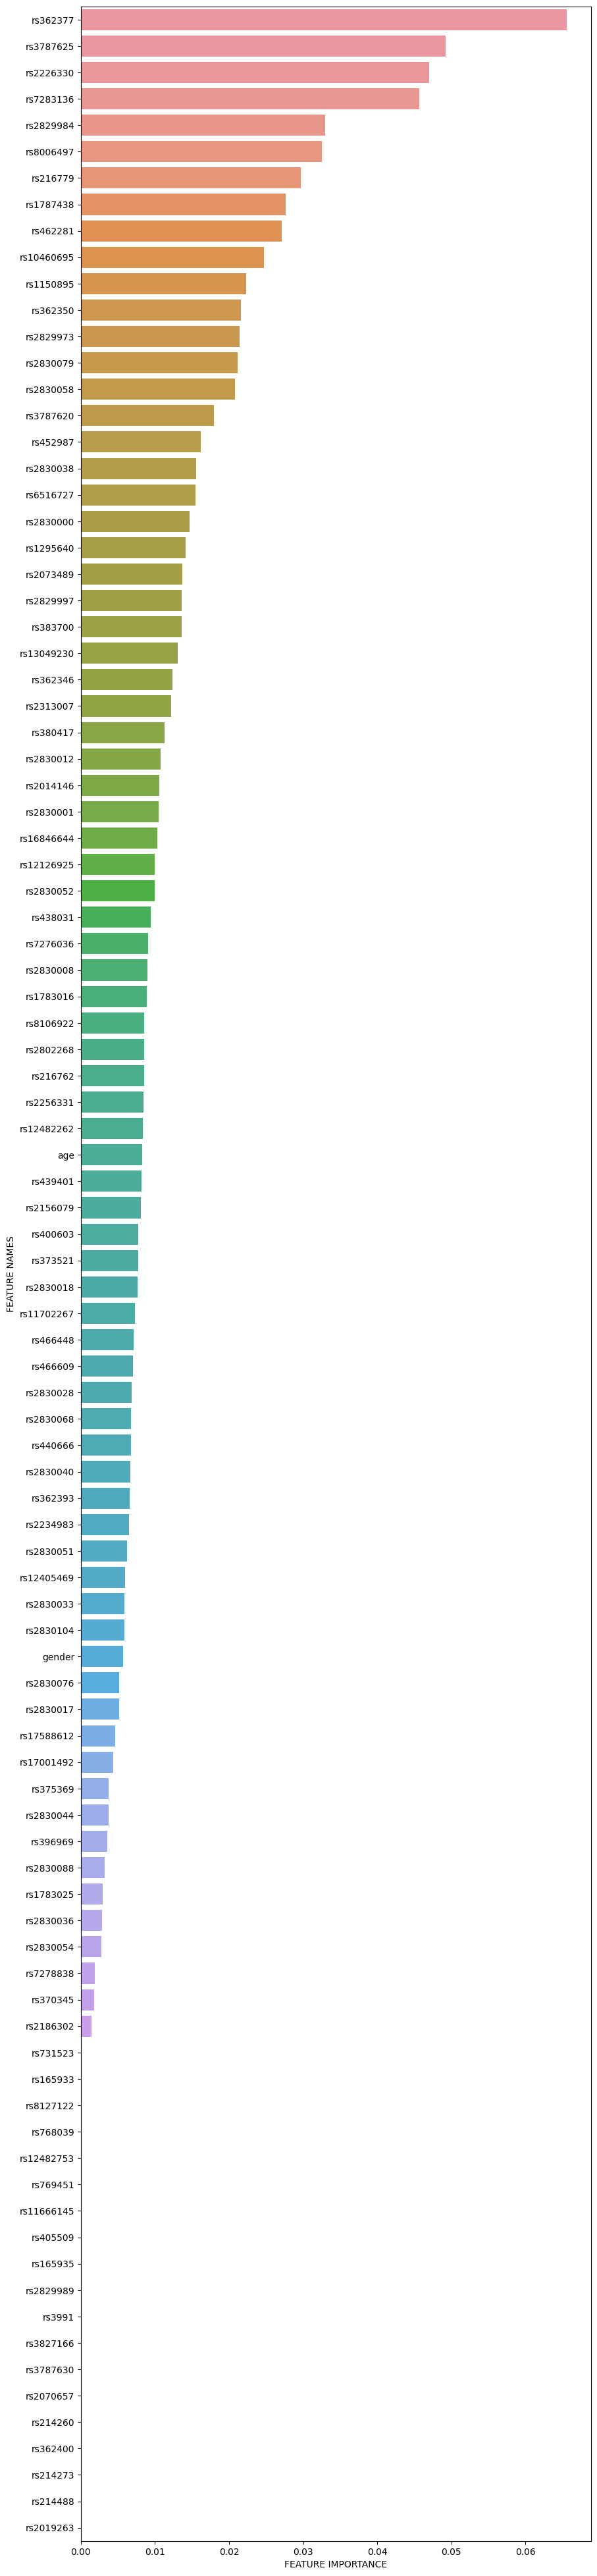

In [74]:
plot_features_importance(xgb_2,x_train_2)

In [75]:
save_load_check(xgb_2,"xgb_2.pkl",x_test_2,y_test_2,1)

The accuracy score is: 69.82758620689656


# Voting

In [76]:
predict_voting_2 = []
for i in range (len(pred_label_rf_2)): 
    voting_list =[0, 0]
    voting_helper_function(pred_label_rf_2 [i],voting_list)
    voting_helper_function(pred_label_xgb_2[i],voting_list)
    predict_voting_2.append(np.argmax(voting_list))
    

print("The predicted labels of the combined classifiers are:",predict_voting_2)
print("The accuracy score of the combined classifiers is",accuracy_score(np.array(y_test_2),np.array(predict_voting_2))*100)

The predicted labels of the combined classifiers are: [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
The accuracy score of the combined classifiers is 70.6896551724138


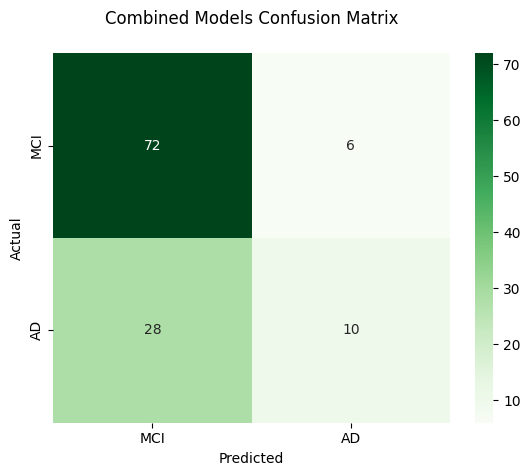

In [77]:
confusion_matrix_print(np.array(y_test_2),predict_voting_2,label_name_2,"Combined Models")